# Predicting Home Prices in Ames 🏡

### **Table of contents:**  

1. Exploratory data analysis
2. Data cleaning
3. Naive model
4. **Feature engineering**
5. **Feature selection and Modelling**
7. **Productionalize**
8. **Predictions and Conclusions**

This notebook contains the sections in bold.

In [1]:
# imports and display options
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFromModel
from sklearn_pandas import DataFrameMapper

import warnings
warnings.simplefilter("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option('max_columns', 100)

In [2]:
df = pd.read_csv('datasets/cleaned_train_data.csv')

In [3]:
df.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,lot_config,neighborhood,condition_1,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,60_MSC,RL,68.879,13517,IR1,Lvl,CulDSac,Sawyer,RRAe,1Fam,2Story,6,8,1976,2005,Gable,HdBoard,Plywood,BrkFace,289.000,4,3,CBlock,3,3,0,GLQ,533.000,Unf,0.000,192.000,725.000,5,1,SBrkr,725,754,0,1479,0.000,0.000,2,1,3,1,4,6,Typ,0,0,Attchd,1976.000,RFn,2.000,475.000,3,3,1,0,44,0,0,0,0,0,Mar,2010,WD,130500
1,60_MSC,RL,43.000,11492,IR1,Lvl,CulDSac,SawyerW,Norm,1Fam,2Story,7,5,1996,1997,Gable,VinylSd,VinylSd,BrkFace,132.000,4,3,PConc,4,3,0,GLQ,637.000,Unf,0.000,276.000,913.000,5,1,SBrkr,913,1209,0,2122,1.000,0.000,2,1,4,1,4,8,Typ,1,3,Attchd,1997.000,RFn,2.000,559.000,3,3,1,0,74,0,0,0,0,0,Apr,2009,WD,220000
2,20_MSC,RL,68.000,7922,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,5,7,1953,2007,Gable,VinylSd,VinylSd,None,0.000,3,4,CBlock,3,3,0,GLQ,731.000,Unf,0.000,326.000,1057.000,3,1,SBrkr,1057,0,0,1057,1.000,0.000,1,0,3,1,4,5,Typ,0,0,Detchd,1953.000,Unf,1.000,246.000,3,3,1,0,52,0,0,0,0,0,Jan,2010,WD,109000
3,60_MSC,RL,73.000,9802,Reg,Lvl,Inside,Timber,Norm,1Fam,2Story,5,5,2006,2007,Gable,VinylSd,VinylSd,None,0.000,3,3,PConc,4,3,0,Unf,0.000,Unf,0.000,384.000,384.000,4,1,SBrkr,744,700,0,1444,0.000,0.000,2,1,3,1,3,7,Typ,0,0,BuiltIn,2007.000,Fin,2.000,400.000,3,3,1,100,0,0,0,0,0,0,Apr,2010,WD,174000
4,50_MSC,RL,82.000,14235,IR1,Lvl,Inside,SawyerW,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,Wd Sdng,Plywood,None,0.000,3,3,PConc,2,4,0,Unf,0.000,Unf,0.000,676.000,676.000,3,1,SBrkr,831,614,0,1445,0.000,0.000,2,0,3,1,3,6,Typ,0,0,Detchd,1957.000,Unf,2.000,484.000,3,3,0,0,59,0,0,0,0,0,Mar,2010,WD,138500


### 4. Feature Engineering

#### *1. Log Transform Skewed Attributes*

In [4]:
# list of all numerical attributes which are continuous
continuous = ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 
'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 
'low_qual_fin_sf']

len(continuous)

14

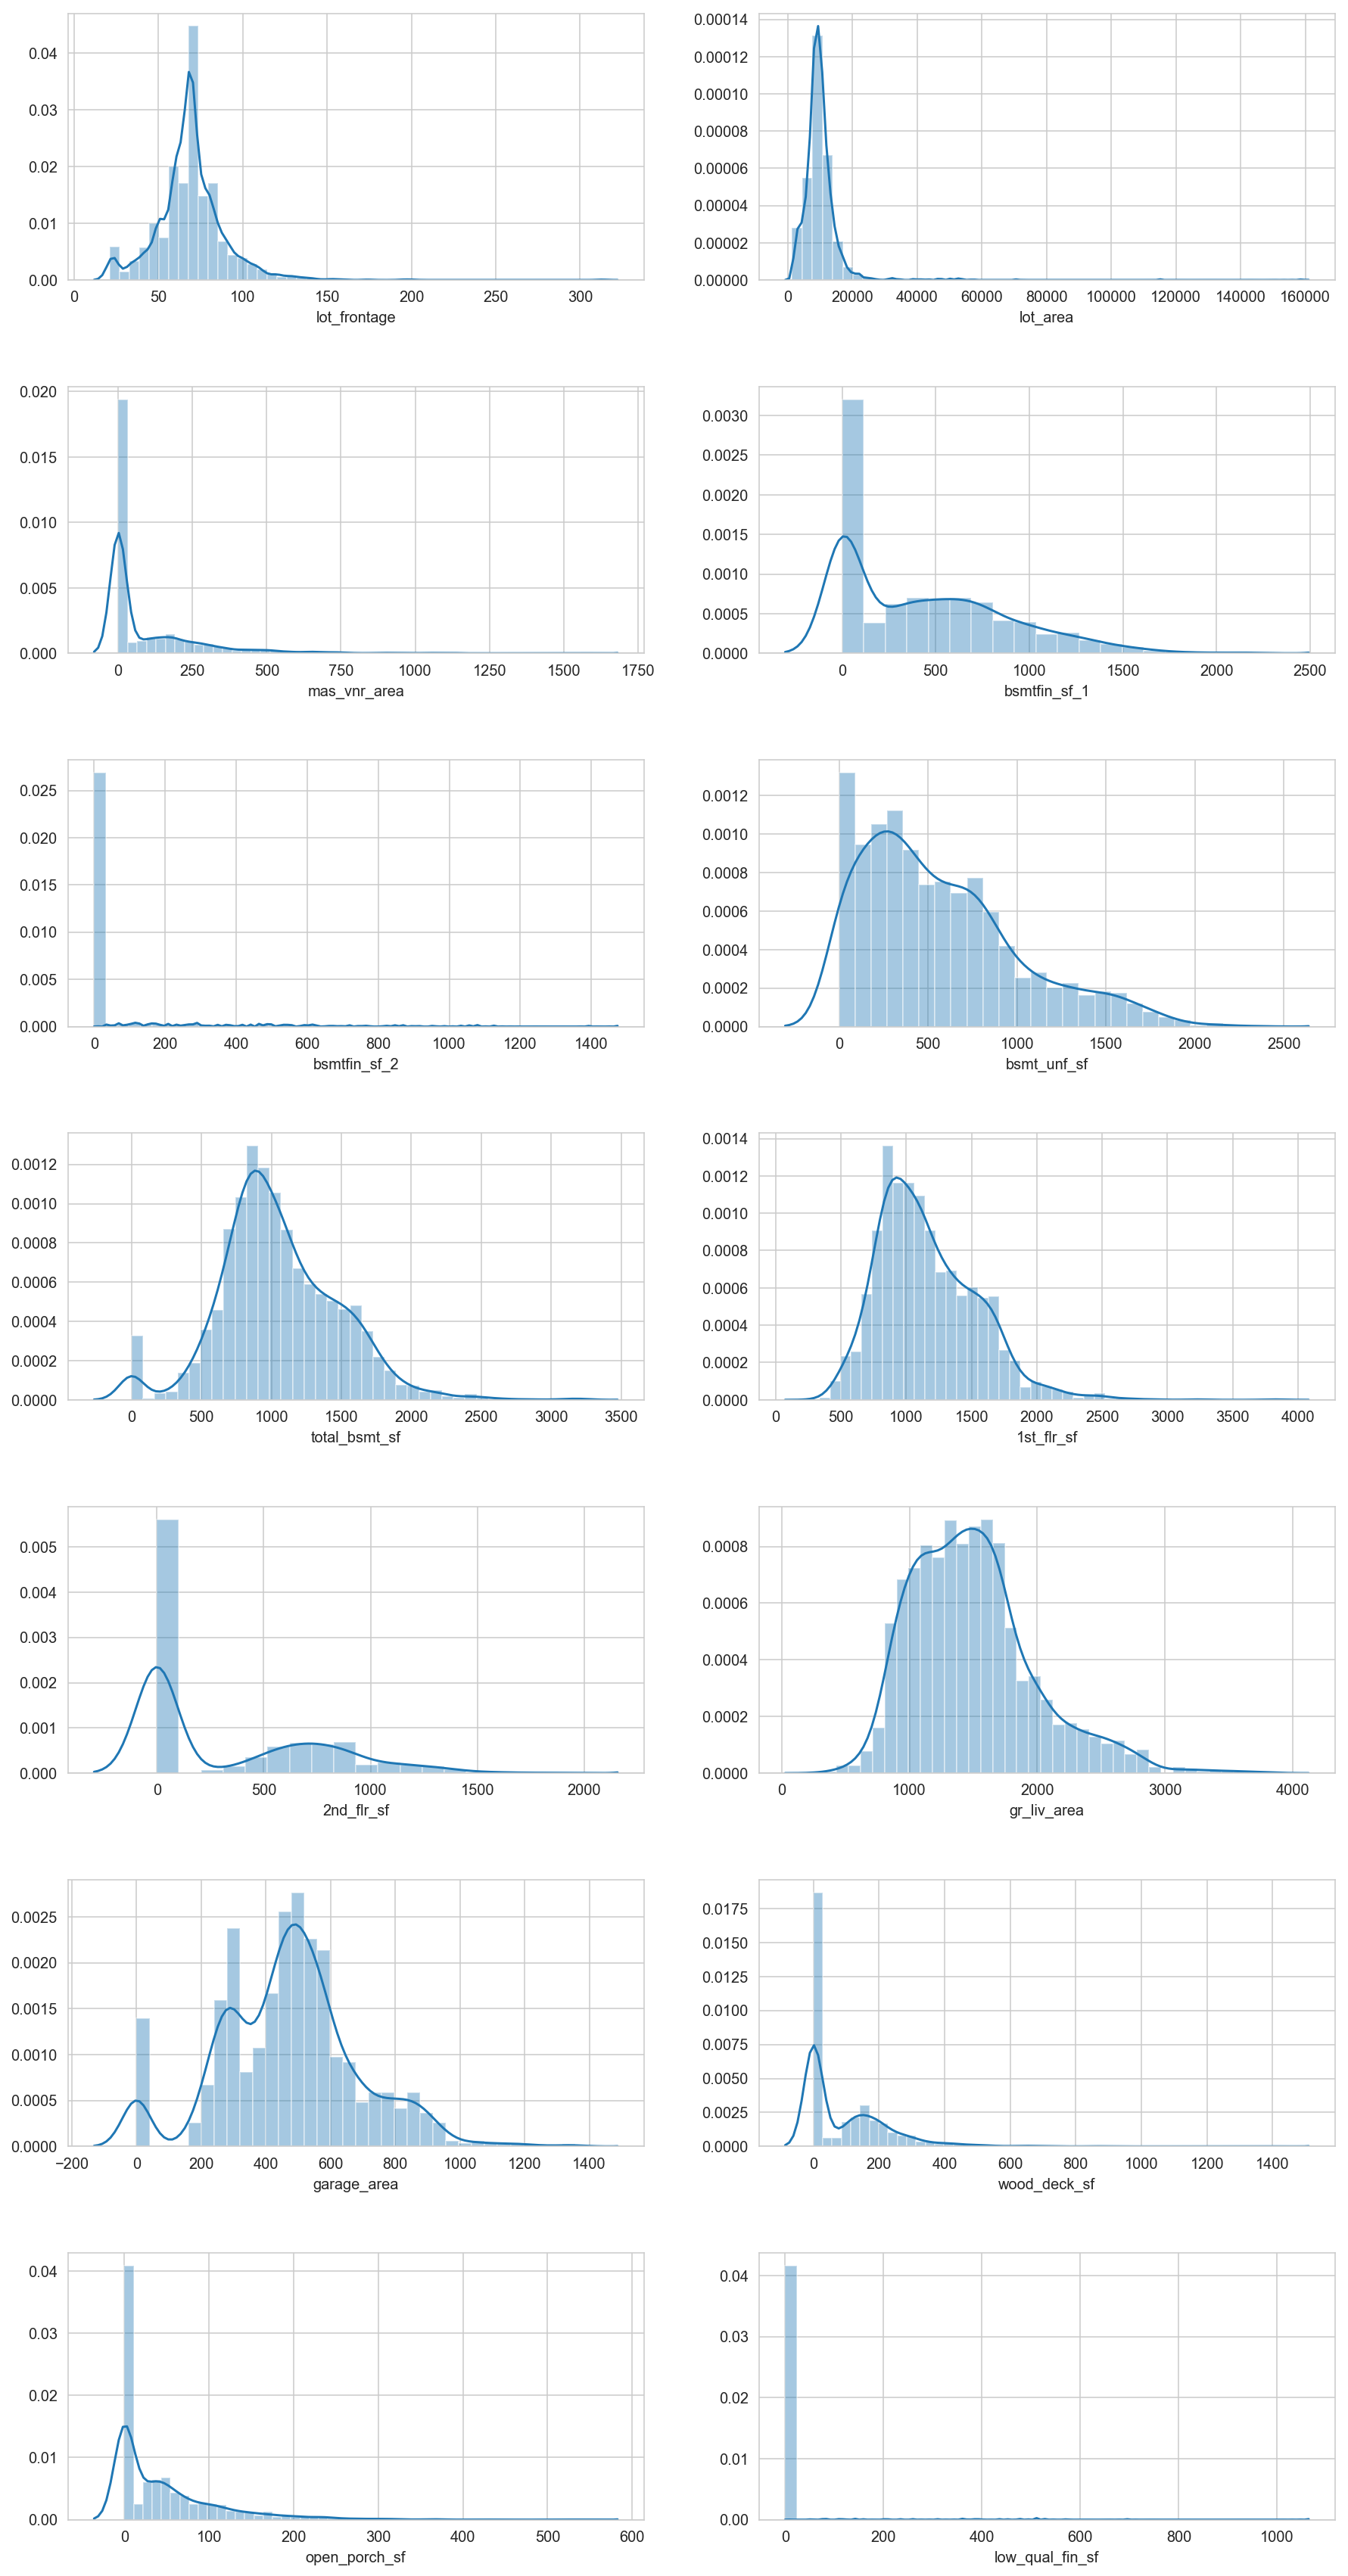

In [5]:
plt.figure(figsize=(15, 35))
# create a distplot for each 
for i, col in enumerate(continuous):
    plt.subplot(8, 2, i+1)
    plt.subplots_adjust(hspace=0.4)
    sns.distplot(df[col]);

These all look right-skewed so a log transformation is appropriate.

In [6]:
# adding +1 to the log transformation to avoid getting -infinity values for the 0s
df[continuous] = df[continuous].apply(lambda x: np.log(x + 1))

#### *2. Create interaction attributes for columns retaed to quality and condition*

I want to create two new columns that will store the product of all the quality columns and all the condition columns, respectively. 

Since some quality/cond values are 0, i need to ensure that those columns won't nullify other scores when multiplied. 

In [7]:
# get quality and condition cols
quality = [col for col in df.columns if col.endswith('qual') or col.endswith('qc') or col.endswith('qu')]
condition = [col for col in df.columns if col.endswith('cond')]
print(quality)
print(condition)

['overall_qual', 'exter_qual', 'bsmt_qual', 'heating_qc', 'kitchen_qual', 'fireplace_qu', 'garage_qual']
['overall_cond', 'exter_cond', 'bsmt_cond', 'garage_cond']


In [8]:
# define a function that will create a list of interaction terms for a given list of columns
def interaction_term(df, category):
    interaction_terms = []
    for i, row in df[category].iterrows():
        # create a copy of the list of columns
        # this is the list in which i'll store all the non-zero columns
        non_zero_cols = category.copy()
        # iterate over each column in the list
        for col in category:
            # if the column is equal to zero, remove it from the non_zero_cols list
            if row[col] == 0:
                non_zero_cols.remove(col)
        # z will store the interaction term
        z = 1
        # iterate over the non_zero_cols list, and multiply each element with each other
        for col in non_zero_cols:
            z = z * df.at[i, col]
        interaction_terms.append(z)
    return interaction_terms

In [9]:
df['quality_interaction'] = interaction_term(df, quality)
df['condition_interaction'] = interaction_term(df, condition)

#### *3. Turn year columns to 'years since'*

Stand alone years don't really mean much. It's how many years that has passed since a house was built/renovated/sold that matters. Let's transform all our year columns.

In [10]:
year_cols = ['year_built', 'year_remod/add', 'yr_sold', 'garage_yr_blt']

In [11]:
def years_since_creator(df, year_cols):
    for col in year_cols:
        name = 'since_' + col
        df[name] = 2019 - df[col]
    # drop the old year columns
    df = df.drop(columns=year_cols, axis=1)
    return df

In [12]:
df = years_since_creator(df, year_cols)

#### *4. Create a column for general living area square footage per inhabitant*

In [13]:
# assuming number of inhabitants will roughly equal number of bedrooms plus one
# one bedroom shared by spouses
df['sf_per_inhabitant'] = df['gr_liv_area'] / (df['bedroom_abvgr'] + 1)

#### *5. Create a column for total number of bathrooms*

In [14]:
# half baths will count as .5 baths
def total_bath_creator(df):
    df['total_bath'] = df['bsmt_full_bath'] + df['bsmt_half_bath'] * 0.5 + df['full_bath'] + df['half_bath'] * 0.5
    # don't need the old bathroom columns anymore
    df = df.drop(columns=['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath'], axis=1)
    return df

In [15]:
df = total_bath_creator(df)

#### *6. Create a column for number of bathrooms per inhabitant*

In [16]:
# adhering to the same assumpting asto the number of inhabitants as before  
df['bath_per_inhabitant'] = df['total_bath'] / (df['bedroom_abvgr'] + 1)

#### *7. Create polynomial features for the attribures with the highest pearson r*

In [17]:
# get attributes with highest r
df.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).head(11)

,saleprice
saleprice,1.000
quality_interaction,0.825
overall_qual,0.803
exter_qual,0.715
gr_liv_area,0.701
kitchen_qual,0.694
garage_cars,0.648
total_bath,0.633
1st_flr_sf,0.616
bsmt_qual,0.613


In [18]:
high_r_cols = list(df.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).head(11).index)
high_r_cols.remove('saleprice')
high_r_cols

['quality_interaction',
 'overall_qual',
 'exter_qual',
 'gr_liv_area',
 'kitchen_qual',
 'garage_cars',
 'total_bath',
 '1st_flr_sf',
 'bsmt_qual',
 'fireplace_qu']

In [19]:
def poly_feature_creator(df, cols):
    poly = PolynomialFeatures(include_bias=False)
    poly.fit(df[cols])
    df_poly = poly.transform(df[cols])
    polynomial_feat = pd.DataFrame(df_poly, columns = poly.get_feature_names(cols))
    # add polynomial features to df, remove existing cols so they are not repeated
    df = df.drop(columns=cols, axis=1)
    df = df.join(polynomial_feat)
    return df

In [20]:
df = poly_feature_creator(df, high_r_cols)

#### *8. Standard Scale*

Let's check for features much bigger in scale compared to others.

In [22]:
desc = df[df.dtypes[df.dtypes != 'object'].index].describe().T
desc.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
quality_interaction^2,2049.000,378277063.172,1012494649.075,64.000,2624400.000,33177600.000,191102976.000,8789062500.000
saleprice,2049.000,181479.018,79295.913,12789.000,129800.000,162500.000,214000.000,611657.000
quality_interaction overall_qual,2049.000,86532.396,140096.776,8.000,8748.000,34560.000,94080.000,937500.000
quality_interaction gr_liv_area,2049.000,85526.254,120180.057,46.513,11257.214,41085.887,102016.035,762082.513
quality_interaction 1st_flr_sf,2049.000,82446.516,116829.564,46.513,11115.972,38529.996,98320.815,733241.445
quality_interaction bsmt_qual,2049.000,48142.021,76203.856,0.000,4860.000,18432.000,48384.000,468750.000
quality_interaction kitchen_qual,2049.000,47594.990,75498.631,16.000,4860.000,17496.000,51840.000,468750.000
quality_interaction exter_qual,2049.000,45872.984,73099.903,16.000,4860.000,17496.000,45360.000,468750.000
quality_interaction fireplace_qu,2049.000,38357.746,68284.999,0.000,0.000,2160.000,45360.000,468750.000
quality_interaction total_bath,2049.000,31160.731,49343.184,8.000,2700.000,11664.000,34020.000,337500.000


Let's standardize these columns.

In [23]:
big = list(desc.sort_values(by='mean', ascending=False).head(20).index)
big.remove('saleprice')

In [24]:
def standard_scaler(df, cols): 
    ss = StandardScaler()
    scaled = ss.fit_transform(df[cols])
    scaled_df = pd.DataFrame(scaled, columns=cols)
    # drop the actual columns, add scaled ones
    df.drop(columns=cols, axis=1, inplace=True)
    return df.join(scaled_df)

In [25]:
df = standard_scaler(df, big)

#### *9. Binarize categorical columns*

In [26]:
# get categorical attributes
categorical = [col for col in df.dtypes[df.dtypes == "object"].index]

In [27]:
# create a mapper list to pass onto a data frame mapper
# label binarize if column is categorical, do nothing if its numerical
mapper = []
X = df.drop(columns='saleprice', axis=1)
for name, values in X.iteritems():
    if name in categorical:
        mapper.append((name, LabelBinarizer()))
    else:
        mapper.append((name, None))

In [28]:
mapper = DataFrameMapper(mapper, df_out = True)
X = mapper.fit_transform(X)

In [29]:
# shape of my final train df
X.shape

(2049, 293)

### 5. Feature Selection and Modelling

#### *1. Multiple Linear Regression*

NOTE: The test dataset here will actually be my validation dataset, since there is a separate test dataset in csv.

In [30]:
# lets first see how a multiple linear regression model would perform if we used ALL the variables
# defined X in previous cell
y = df.saleprice
# train test split our training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9545733515979916

In [32]:
# r2 score
np.set_printoptions(suppress=True)
model.score(X_test, y_test)

0.9418018703442946

In [33]:
# root mean squared error
# how off the predicted prices are from the actual price
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

18631.995965685797

In [34]:
# define a function to plot the residuals
def residual_plotter(model, model_name):    
    y_pred = model.predict(X_test)
    plt.figure(figsize=(12,5));
    residuals = y_pred - y_test
    plt.scatter(y_test, residuals, alpha=0.5);
    plt.xlabel('Actual prices', fontsize=15, fontname='serif');
    plt.ylabel('Residuals', fontsize=15, fontname='serif');
    plt.axhline(0, c = 'red');
    title = 'Residuals against actual home prices - ' + model_name
    plt.title(title, fontsize=25, loc='left', fontname='serif');

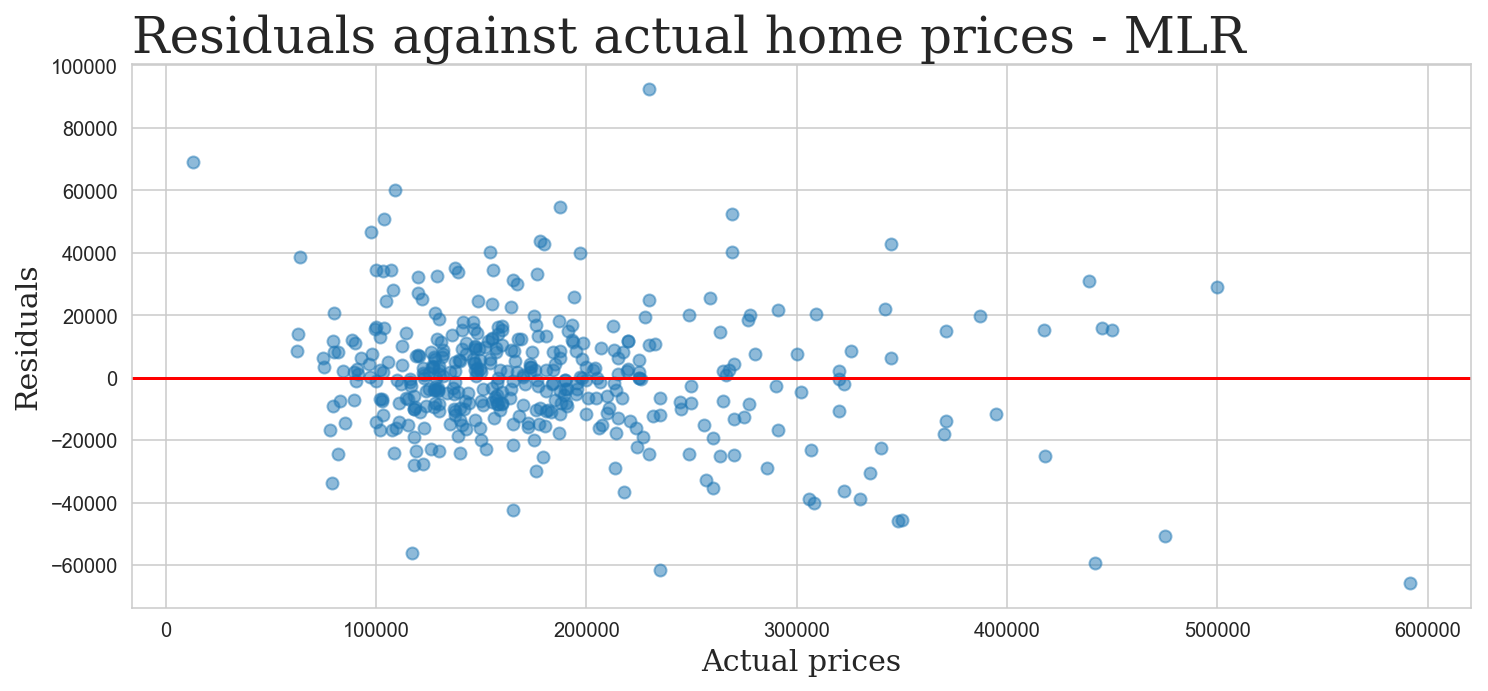

In [35]:
residual_plotter(model, 'MLR') 

Thats pretty good.. I'll also try some regularized regression and automated feature selection techniques.

#### *2. Ridge Regression*

In [36]:
# first, set up a list of ridge alphas to check to find the most optimal alpha
ridge_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=ridge_alphas, cv=10)
ridge_model.fit(X_train, y_train)
optimal_alpha = ridge_model.alpha_
print(optimal_alpha)

1.7834308769319096


In [37]:
ridge_opt = Ridge(alpha=optimal_alpha)
ridge_opt.fit(X_train, y_train)
ridge_opt.score(X_train, y_train)

0.9489386228433146

In [38]:
ridge_opt.score(X_test, y_test)

0.9412253369030872

In [39]:
# root mean squared error
y_pred = ridge_opt.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

18724.056451478573

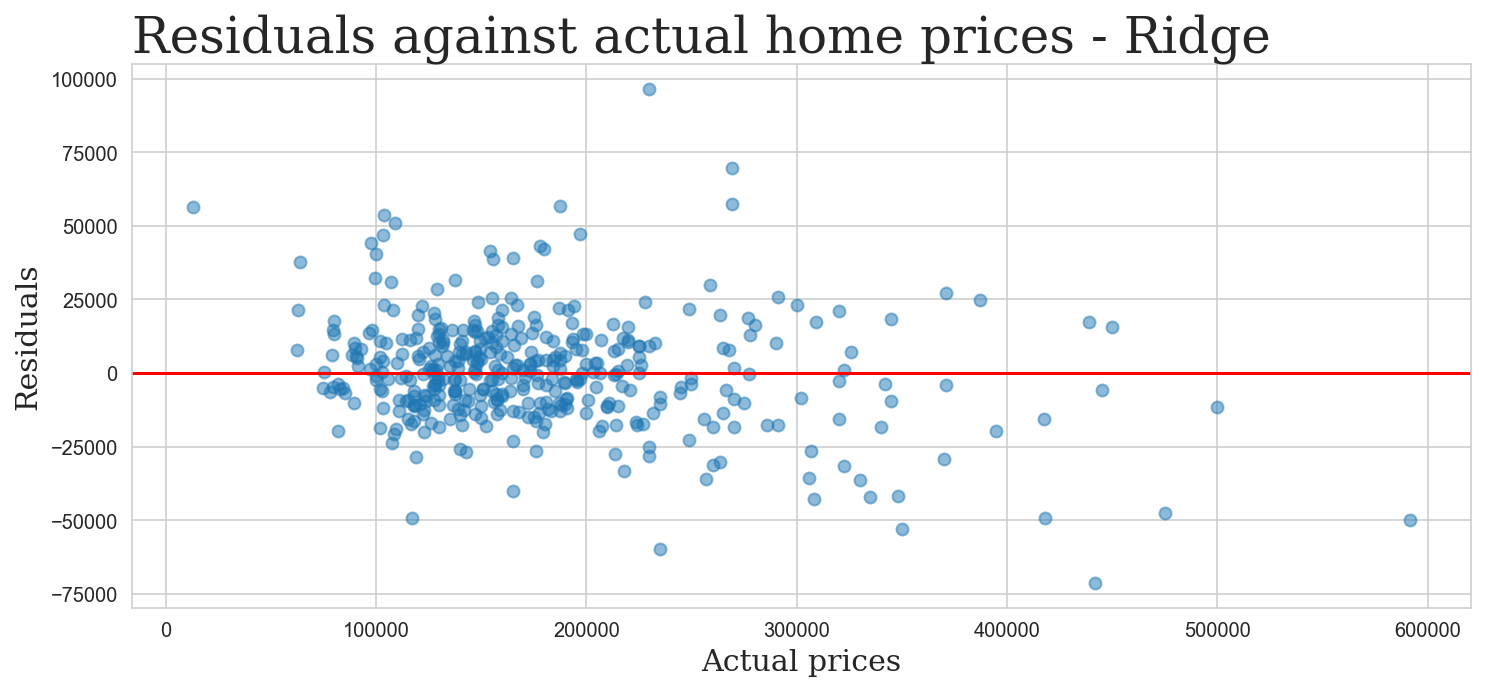

In [40]:
residual_plotter(ridge_opt, 'Ridge') 

#### *3. Lasso Regression*

In [41]:
# let scikit learn choose the optimal alpha from amongst 500 attempts
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso.fit(X_train, y_train)
print(optimal_lasso.alpha_)

1203.939009642556


In [42]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

0.9002370122058253

In [43]:
lasso.score(X_test, y_test)

0.8965861700671213

In [44]:
# root mean squared error
y_pred = lasso.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

24836.71643312161

In [45]:
# lasso performed worse than MLS and Ridge
# let's see which coefficients it decided to eliminate
np.set_printoptions(suppress=True)
coefs = pd.DataFrame({'columns': X_train.columns, 'lasso_coefficients': lasso.coef_})
print(coefs[np.abs(coefs.lasso_coefficients) > 0].shape)
coefs[np.abs(coefs.lasso_coefficients) > 0].sort_values(by='lasso_coefficients', ascending=False)

(28, 2)


,columns,lasso_coefficients
282,quality_interaction total_bath,16340.470
288,gr_liv_area 1st_flr_sf,14008.057
24,lot_area,11205.209
283,quality_interaction garage_cars,6124.145
88,overall_cond,3892.653
138,bsmt_exposure,2557.055
287,gr_liv_area^2,2074.816
146,bsmtfin_sf_1,1427.234
236,overall_qual garage_cars,1335.127
168,totrms_abvgrd,1257.149


From 293 columns, lasso only kept 28. However, the $r^{2}$ was worse than the previous two models. 

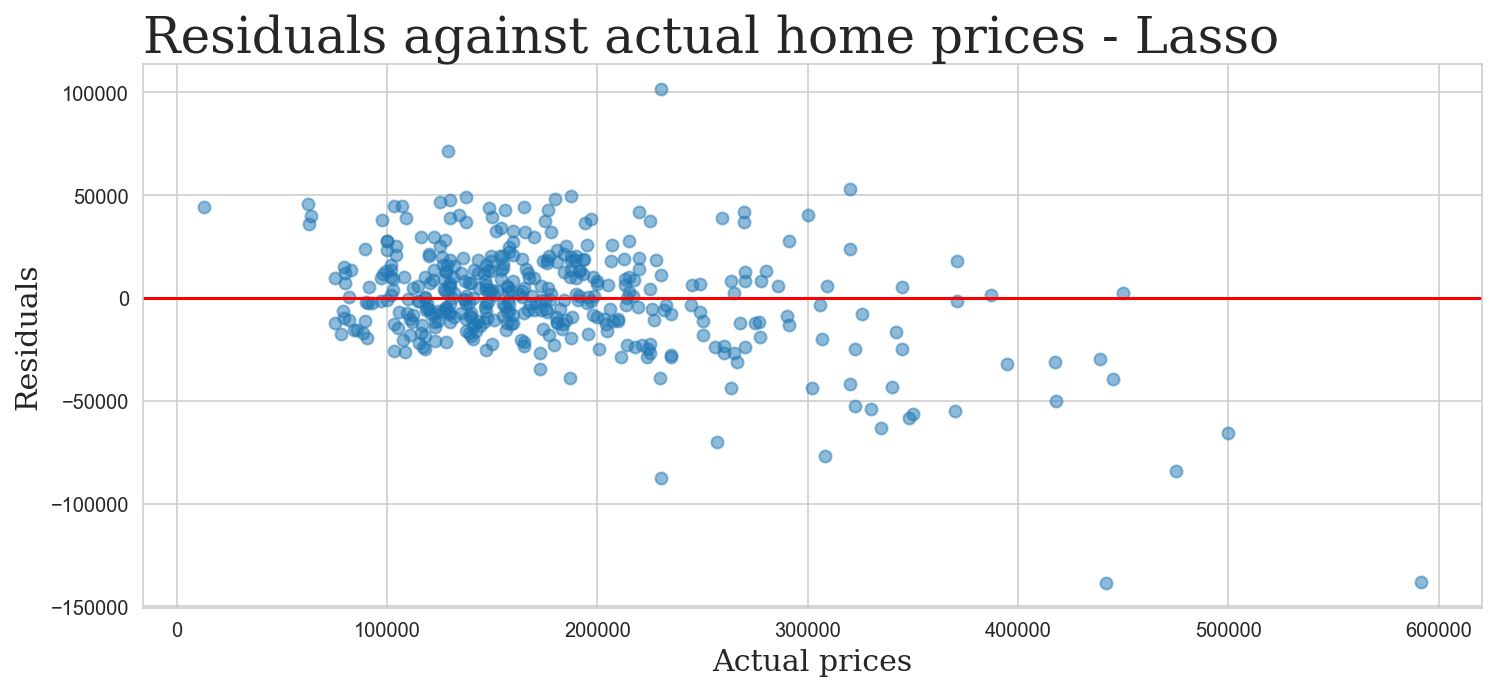

In [46]:
residual_plotter(lasso, 'Lasso') 

#### *4. ElasticNet CV*

In [47]:
# try a mix of ridge and lasso 
optimal_enet = ElasticNetCV(n_alphas=500, cv=10)
optimal_enet.fit(X_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio)

2407.8780192851123
0.5


In [48]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet.fit(X_train, y_train)
enet.score(X_train, y_train)

0.6587879489459059

In [49]:
enet.score(X_test, y_test)

0.6408172214655545

In [50]:
# root mean squared error
y_pred = enet.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

46287.382273530355

Much worse than the previous models. Let's try K Neighbours regression.

#### *5. K-Neighbors Regression*

In [51]:
knn = neighbors.KNeighborsRegressor()
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
model.best_params_

{'n_neighbors': 7}

In [52]:
model = neighbors.KNeighborsRegressor(n_neighbors = 6)
model.fit(X_train, y_train) 
model.score(X_test, y_test)

0.7741266171778479

In [53]:
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

36706.028351556335

MLR and Ridge were the best performers.

#### *6. Univariate Feature Selection*

I'll pass all the selected features to MLR and Ridge models and see if there is a performance improvement.

In [54]:
percentiles = list(np.arange(10, 100, 5))

In [55]:
linreg = []
ridge = []

for p in percentiles:
    # select p percentile of the attributes
    select = SelectPercentile(percentile=p)
    select.fit(X_train, y_train)
    X_train_selected = select.transform(X_train)
    X_test_selected = select.transform(X_test)
    
    # linear regression with different ps
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    score = model.score(X_test_selected, y_test)
    linreg.append((p, score))
    
    # ridge regression with different ps
    ridge_opt = Ridge(alpha=optimal_alpha)
    ridge_opt.fit(X_train_selected, y_train)
    r_score = ridge_opt.score(X_test_selected, y_test)
    ridge.append((p, r_score))

In [56]:
linreg

[(10, 0.9047350298362231),
 (15, 0.9050008736275187),
 (20, 0.9033677674658114),
 (25, 0.9016904354857076),
 (30, 0.8993036347131907),
 (35, 0.8962640753021401),
 (40, 0.9065666983017607),
 (45, 0.910564976807987),
 (50, 0.9275430696422111),
 (55, 0.92597240720467),
 (60, 0.9342477243288105),
 (65, 0.9335912794514754),
 (70, 0.9376297694198629),
 (75, 0.9373901180243497),
 (80, 0.9419842628389336),
 (85, 0.9420742195162618),
 (90, 0.9424642771928715),
 (95, 0.9428126712976572)]

In [57]:
ridge

[(10, 0.8909006265640154),
 (15, 0.8939311283098256),
 (20, 0.8928972406951086),
 (25, 0.8927826674911508),
 (30, 0.8941079906495485),
 (35, 0.9004677048190511),
 (40, 0.9078869980459023),
 (45, 0.9127408777142992),
 (50, 0.9252057017313565),
 (55, 0.9234332425833077),
 (60, 0.9294277347893892),
 (65, 0.9293684707196864),
 (70, 0.9322781163851234),
 (75, 0.9348216245983944),
 (80, 0.9398092479817284),
 (85, 0.9403550459940185),
 (90, 0.940621137407182),
 (95, 0.9412689500448561)]

MLR with 95% of attributes scored the highest $r^{2}$ yet.

In [58]:
k_best = list(np.arange(50, 293, 25))

In [59]:
linreg_k = []
ridge_k = []

for k in k_best:
    # select k best of the attributes
    select = SelectKBest(k=k)
    select.fit(X_train, y_train)
    X_train_selected = select.transform(X_train)
    X_test_selected = select.transform(X_test)
    
    # linear regression with different ks
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    score = model.score(X_test_selected, y_test)
    linreg_k.append((k, score))
    
    # ridge regression with different ks
    ridge_opt = Ridge(alpha=optimal_alpha)
    ridge_opt.fit(X_train_selected, y_train)
    r_score = ridge_opt.score(X_test_selected, y_test)
    ridge_k.append((k, r_score))

In [60]:
linreg_k

[(50, 0.9038624427263269),
 (75, 0.9015098278501814),
 (100, 0.8919537607720596),
 (125, 0.9084996407327393),
 (150, 0.9266659476930005),
 (175, 0.9342769115071556),
 (200, 0.9368731214596161),
 (225, 0.9416350757649204),
 (250, 0.9421663160413332),
 (275, 0.942526574664579)]

In [61]:
ridge_k

[(50, 0.8933224274779268),
 (75, 0.8925810532532434),
 (100, 0.8984918194453371),
 (125, 0.9114457341949704),
 (150, 0.9244349858564306),
 (175, 0.9290795789418278),
 (200, 0.9319440538793322),
 (225, 0.9388782105597794),
 (250, 0.9403307409659888),
 (275, 0.941412614333833)]

Different variations of feature selection did not enhance the predictive power of the model, and it seems like the more features there are, the higher is the test score. Next, I will create a pipeline for all the data transformations I've performed here, and pass the actual test data set to it for submission to Kaggle. 

**The chosen model is... Multiple Linear Regression with 95% of the best features!**

*Test score: 94.28%*

### 6. Productionalize

I performed A LOT of transformations on the data. Now, I need to create a pipeline that can take new, untouched data, apply every single thing I did on it and predict the price.

Here is a list of things I need to add in the pipeline:
- Remove columns with too many nulls.
- Remove ID columns.
- Remove 'same category' columns.
- Impute nan values.
- Encode the quality & conditions columns as numbers.
- Fix Basement exposure column.
- Encode binary columns as numbers.
- Turn the values in the Months Sold column to strings.
- Fix MsSubClass column.
- Tidy up column names.
- Log transform continuous numerical attributes.
- Create an interaction term for quality columns.
- Create an interaction term for condition columns.
- Turn year columns to years since.
- Create a column for general living area square footage per inhabitant
- Create a column for total number of bathrooms
- Create a column for number of bathrooms per inhabitant
- Standard scale columns with high scale.
- Label binarize all categorical attributes.

In [62]:
# repeat everything that was done in cleaning
def clean(df):
    # remove all the rows i decided to remove
    too_many_nulls = ['Pool QC', 'Misc Feature', 'Alley', 'Fence']
    #id_cols = ['Id', 'PID']
    id_cols = ['Id']
    same_category = ['Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating']
    to_drop = same_category + id_cols + too_many_nulls
    df.drop(columns=to_drop, axis=1, inplace=True)
    # fill nans in numeric columns with 0s
    numeric_columns = df.dtypes[df.dtypes != 'object'].index
    df[numeric_columns] = df[numeric_columns].fillna(0)
    #fill nans in categorical columns with 'None'
    categorical_columns = df.dtypes[df.dtypes == 'object'].index
    df[categorical_columns] = df[categorical_columns].fillna('None')
    # encode all the ranked rows as numbers
    quality_and_cond = ['Exter Qual', 'Bsmt Qual', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 
    'Garage Qual', 'Exter Cond', 'Bsmt Cond', 'Garage Cond']
    df[quality_and_cond] = df[quality_and_cond].replace({'Ex': 5, 
                                                         'Gd': 4, 
                                                         'TA': 3, 
                                                         'Fa': 2, 
                                                         'Po': 1, 
                                                         'None': 0})
    # fix Basement exposure
    df['Bsmt Exposure'] = df['Bsmt Exposure'].replace({'No': 0, 
                                                       'None': 0, 
                                                       'Gd': 3, 
                                                       'Av': 2, 
                                                       'Mn': 1})
    # encode binary columns as 1-0s 
    df['Central Air'] = np.where(df['Central Air'] == 'Y', 1, 0)
    df['Paved Drive'] = np.where(df['Paved Drive'] == 'Y', 1, 0)
    # turn months in Mo Sold to strings 
    dict = {}
    for month_idx in range(1, 13):
        dict[month_idx] = calendar.month_abbr[month_idx]
    df['Mo Sold'] = df['Mo Sold'].replace(dict)
    # turn MS SubClass column to str since it's a category
    df['MS SubClass'] = df['MS SubClass'].apply(str) + '_MSC'
    # fix the column names
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    return df

In [63]:
# repeat everything that was done in feature engineering
def engineer(df):
    # log transform right skewed columns
    df[continuous] = df[continuous].apply(lambda x: np.log(x + 1))
    # create interaction terms for quality and condition columns
    df['quality_interaction'] = interaction_term(df, quality)
    df['condition_interaction'] = interaction_term(df, condition)
    # turn year columns to years since
    df = years_since_creator(df, year_cols)
    # create feature for total number of bathrooms
    df = total_bath_creator(df)
    # create feature for general living area square footage per inhabitant
    df['sf_per_inhabitant'] = df['gr_liv_area'] / (df['bedroom_abvgr'] + 1)
    # create feature for bathrooms per inhabitant
    df['bath_per_inhabitant'] = df['total_bath'] / (df['bedroom_abvgr'] + 1)
    # create the polynomial columns
    df = poly_feature_creator(df, high_r_cols)
    # standard scale cols big in scale
    df = standard_scaler(df, big)
    return df

### 7. Predictions for Kaggle & Conclusions

In [64]:
# import test dataset from kaggle 
# it is slightly different than the general assembly one 
kaggle = pd.read_csv('kaggle-data/test.csv')
test = pd.read_csv('datasets/test.csv')

In [65]:
kaggle.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [66]:
ids = kaggle[['Id']]

In [67]:
# align the columns of the kaggle dataset with the columns learned by the model
# the test dataset on kaggle has a column called SaleCondition which we don't have in our train dataset
# it is also missing the PID column, which our train dataset had
proper_cols = list(test.columns)
proper_cols.append('Sale Condition')
proper_cols.remove('PID') 

In [68]:
kaggle.columns = proper_cols

In [69]:
kaggle = clean(kaggle)
kaggle = engineer(kaggle)
kaggle = mapper.transform(kaggle)

In [70]:
select = SelectPercentile(percentile=95)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
kaggle_selected = select.transform(kaggle)

model = LinearRegression()
model.fit(X_train_selected, y_train)
kaggle_predictions = model.predict(kaggle_selected)

In [71]:
ids['SalePrice'] = kaggle_predictions

In [72]:
ids.head()

,Id,SalePrice
0,1461,124905.854
1,1462,163481.755
2,1463,175322.559
3,1464,188094.871
4,1465,200971.120


In [73]:
ids.to_csv('kaggle-data/predictions.csv', index=False)

### Conclusions



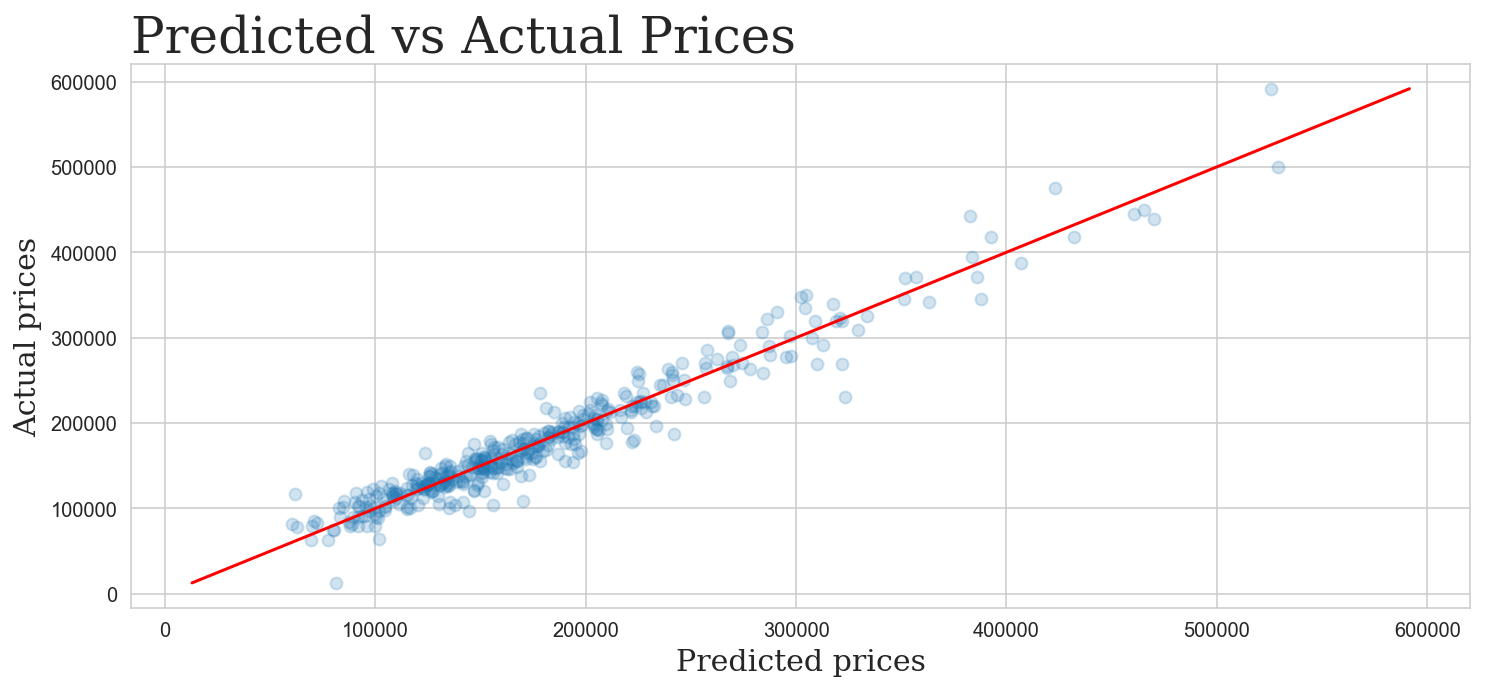

In [74]:
X_test_selected = select.transform(X_test)
y_pred = model.predict(X_test_selected)
plt.figure(figsize=(12, 5))
plt.scatter(y_pred, y_test, alpha=1/5);
plt.title('Predicted vs Actual Prices', fontname='serif', loc='left', fontsize=25);
plt.ylabel('Actual prices', fontname='serif', fontsize=15)
plt.xlabel('Predicted prices', fontname='serif', fontsize=15)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], c = 'red');

In [76]:
# columns picked by select
cols_df = pd.DataFrame(X_train.columns, list(select.get_support())).reset_index()
selected_cols = list(cols_df[cols_df['index'] == True][0])
coeffs = list(model.coef_)

In [79]:
# coefficients
pd.DataFrame({'columns': selected_cols, 'coeffs': coeffs}).sort_values(by='coeffs', ascending=False).head(10)

,columns,coeffs
261,quality_interaction gr_liv_area,271894.862
262,quality_interaction 1st_flr_sf,218124.353
273,gr_liv_area 1st_flr_sf,135465.719
45,neighborhood_GrnHill,119314.020
217,fireplace_qu,60442.043
208,bath_per_inhabitant,35064.054
272,gr_liv_area^2,34067.480
260,quality_interaction overall_qual,30136.753
216,bsmt_qual,30038.042
6,ms_subclass_45_MSC,29612.194


- Multiple Linear Regression, Lasso, Ridge, Elastic Net and K Neighbours Regression models were tried. Optimal hyperparameters were found and used in the latter 4 models through Cross Validation and Grid Search. 
- ANOVA and k-best feature selection were utilized, however it was seen that the more features were included, the better was the performance. Though the number of features was high, the model did not seem to suffer from overfitting. 
- In the end, Multiple Linear Regression with **95%** of top performing attributes had the highest predictability.
- Model built has **94.28%** accuracy on the test data set and is on average **~18500** dollars off from actual prices.
- Feature engineering was the biggest component of this project. The coefficients of the resulting model prove that these efforts paid off. The features that had the biggest coefficients were nearly all engineered features!
- Predictions were submitted to Kaggle and achieved a root mean squared error of **0.14** between the logarithm of the predicted value and the logarithm of the observed sales price.